# Loading in csv file with photometry results

In [8]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_original=pd.read_csv('/users/adignan/photometry_results.csv')
sourcesdf=pd.read_csv('/users/adignan/photometry_sources.csv')
sources=sourcesdf['Source ID']

df_original['SNR > 3?'] = ['YES' if x > 3 else 'NO' for x in df_original['SNR']]
df=df_original[['source ID','freq (GHz)','flux density (mJy)','error (mJy)','SNR > 3?']]

df=df.rename(columns={"source ID":"sourceid","freq (GHz)":"freq","flux density (mJy)": "flux", 
                      "error (mJy)": "error", "SNR > 3?": "snr_ratio"})

# np.select and define list of condition with corresponding values
df['data']=(np.select([df['snr_ratio'].eq('YES'), # condition #1
                         df['snr_ratio'].eq('NO')],# condition #2
                        [df['flux'],            # value when #1 is true
                         3*df['error']]))           # value when #2 is true

df['data_err']=(np.select([df['snr_ratio'].eq('YES'), # condition #1
                         df['snr_ratio'].eq('NO')], # condition #2
                        [df['error'], # value when #1 is true
                         0.0]))        # value when #2 is true

df['lims']=(np.select([df['snr_ratio'].eq('YES'), # condition #1
                         df['snr_ratio'].eq('NO')], # condition #2
                        [False, # value when #1 is true
                         True]))       # value when #2 is true

df['marker']=(np.select([df['snr_ratio'].eq('YES'), # condition #1
                         df['snr_ratio'].eq('NO')], # condition #2
                        ['o', # value when #1 is true
                         'o']))       # value when #2 is true

# nondetections=['NGC0628','NGC3521','NGC3521Enuc.1','NGC3521Enuc.3','NGC3938Enuc.2a','NGC3938a',
#             'NGC3938b','NGC4254f','NGC4321Enuc.1','NGC4321Enuc.2','NGC4321Enuc.2a','NGC4321Enuc.2b',
#               'NGC6946Enuc.5a','NGC7331']

ids=['NGC0337a','NGC0337b','NGC0337d','NGC2798','NGC2841',
    'NGC3049','NGC3184','NGC6946Enuc.7','NGC6946Enuc.8','NGC6946Enuc.9',
    'NGC3190','NGC3198','NGC3351a','NGC3351b','NGC3627Enuc.2',
    'NGC3773','NGC4254b','NGC4321a','NGC4321b','NGC4569',
    'NGC4579','NGC4594a','NGC6946a','NGC6946b','NGC6946c',
    'NGC6946Enuc.2b','NGC6946Enuc.3b','NGC6946Enuc.4a','NGC6946Enuc.4c',
    'NGC6946Enuc.6a','NGC6946Enuc.6b']

df_filt = df[df.sourceid.isin(ids)]

df_filt

,sourceid,freq,flux,error,snr_ratio,data,data_err,lims,marker
0,NGC0337a,3,1.720551,0.134939,YES,1.720551,0.134939,0,o
1,NGC0337a,15,1.252183,0.124283,YES,1.252183,0.124283,0,o
2,NGC0337a,33,0.604797,0.109020,YES,0.604797,0.109020,0,o
3,NGC0337a,90,0.599209,0.107580,YES,0.599209,0.107580,0,o
4,NGC0337b,3,4.663468,0.134980,YES,4.663468,0.134980,0,o
...,...,...,...,...,...,...,...,...,...
243,NGC6946b,90,12.300116,0.120326,YES,12.300116,0.120326,0,o
244,NGC6946c,3,3.763958,0.170690,YES,3.763958,0.170690,0,o
245,NGC6946c,15,2.889158,0.124608,YES,2.889158,0.124608,0,o
246,NGC6946c,33,1.309711,0.228241,YES,1.309711,0.228241,0,o


In [32]:
from scipy.optimize import curve_fit
import sys

freqs=[]
datas=[]
errs=[]

for i in range(31):
        
        #3 to 90 GHz
        data=df_filt[i*4:i*4+4]
        index = data[data['snr_ratio'] == 'NO'].index

        if (len(index) == 0):
            for freq in data.freq.tolist():
                freqs.append(freq)
            for d in data.data.tolist():
                datas.append(d)
            for err in data.data_err.tolist():
                errs.append(err)
        
        f=np.vstack([freq for freq in freqs])
        d=np.vstack([data for data in datas])
        e=np.vstack([err for err in errs])
        mcmcfile = np.hstack((f, d, e))
        
        header= 'frequency (GHz) | flux density (mJy) | flux density error (mJy)'
        
        np.savetxt('/users/adignan/mcmcfiles/'+str(data.sourceid.unique()[0]),X=mcmcfile,header=header)
        
        
        
        
        i=+4

# Creating plots of fluxes for each source

## Spectral line index fitting

In [21]:
from scipy.optimize import curve_fit
import sys
from itertools import repeat

alpha1vals=[]
b1vals=[]
alpha1err=[]

alpha2vals=[]
b2vals=[]
alpha2err=[]

# alphavals=[]
# bvals=[]

def func_fit(a,x,b):
    return a*x + b

for i in range(63):
        
        #3 to 33 GHz
        data1=df[i*4:i*4+3]
        index1 = data1[data1['snr_ratio'] == 'NO'].index
        data1_short=data1.drop(index1, inplace=False)
        #33 to 90 GHz
        data2=df[i*4+2:i*4+4]
        index2 = data2[data2['snr_ratio'] == 'NO'].index
#         #3 to 90 GHz
#         data=df[i*4:i*4+4]
#         index = data[data['snr_ratio'] == 'NO'].index
#         data.drop(index,inplace=True)

        if ((len(index1)) == 3) or ((len(index1)) == 2):
            popt1 = [np.nan, np.nan]
            pcov1 = np.empty((2,2))
            pcov1[:] = np.nan
        if ((len(index1)) == 1) or ((len(index1)) == 0):
            sigma=0.434*data1.data_err/data1.data
            print(sigma)
            popt1, pcov1 = curve_fit(f=func_fit, xdata=np.log10(data1.freq.tolist()), ydata=np.log10(data1.data.tolist()),sigma=0.434*data1.data_err/data1.data)
            
        if (len(index2)) != 0:
            popt2 = [np.nan, np.nan]
            pcov2 = np.empty((2,2))
            pcov2[:] = np.nan
        else:
            popt2, pcov2 = curve_fit(f=func_fit, xdata=np.log10(data2.freq.tolist()), ydata=np.log10(data2.data.tolist()),sigma=0.434*data2.data_err/data2.data)
        
#         if (len(index)) == 3 or (len(index)) == 4:
#             popt = [np.nan, np.nan]
#             pcov = np.empty((2,2))
#             pcov[:] = np.nan
#         else:
#             popt, pcov = curve_fit(f=func_fit, xdata=np.log10(data.freq.tolist()), ydata=np.log10(data.data.tolist()),sigma=0.434*data.data_err/data.data)
        
        
        alpha1,b1=popt1
        alpha2,b2=popt2
#         alpha,b=popt
        
        alpha1vals.append(alpha1)
        b1vals.append(b1)
            
        alpha2vals.append(alpha2)
        b2vals.append(b2)
        
#         alphavals.append(alpha)
#         bvals.append(b)

        i=+4
        
specdf = pd.DataFrame(np.column_stack([df['sourceid'].unique(), alpha1vals, b1vals, alpha2vals, b2vals]), 
                               columns=['source ID', 'alpha1', 'b1',
                                        'alpha2','b2'])

# specdf.to_csv('/users/adignan/specdf.csv')
specdf

0    0.034038
1    0.043076
2    0.078232
dtype: float64
4    0.012562
5    0.021443
6    0.033779
dtype: float64
8     0.081131
9     0.109036
10    0.000000
dtype: float64
12    0.071974
13    0.067456
14    0.123972
dtype: float64
20    0.033061
21    0.067389
22    0.100141
dtype: float64
24    0.061263
25    0.000000
26    0.097695
dtype: float64
28    0.051626
29    0.067462
30    0.103330
dtype: float64
32    0.099310
33    0.105702
34    0.140632
dtype: float64
36    0.119417
37    0.129958
38    0.000000
dtype: float64
40    0.001027
41    0.005912
42    0.011414
dtype: float64
44    0.013295
45    0.029367
46    0.014934
dtype: float64
48    0.014365
49    0.022414
50    0.027563
dtype: float64
52    0.031598
53    0.059995
54    0.067112
dtype: float64
56    0.012269
57    0.037426
58    0.052424
dtype: float64
60    0.028563
61    0.033190
62    0.120616
dtype: float64
64    0.007288
65    0.010550
66    0.022890
dtype: float64
68    0.006964
69    0.009701
70    0.020781
d

/users/adignan/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/users/adignan/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


,source ID,alpha1,b1,alpha2,b2
0,NGC0337a,-0.310051,0.397007,-0.009251,-0.204343
1,NGC0337b,-0.431207,0.878129,0.034834,0.116091
2,NGC0337c,1.0,1.0,NaN,NaN
3,NGC0337d,-0.10495,-0.015919,-0.398325,0.291438
4,NGC0628,NaN,NaN,NaN,NaN
...,...,...,...,...,...
58,NGC6946Enuc.9,-0.068033,0.355126,0.289991,-0.218059
59,NGC6946a,0.09668,0.005781,0.206136,-0.227949
60,NGC6946b,-0.526262,1.938898,-0.048308,1.184315
61,NGC6946c,-0.208739,0.683511,0.32165,-0.371255


## Actual plotting

In [17]:
def func_plot(x,a,b):
    return (x**a) * (10**b)


for i in range(63):

        data=df[i*4:i*4+4]
        title=df.iloc[i*4]
        print(title)
    
        plt.figure()

        
        for idx in data.index.tolist():
            plt.errorbar(data.freq[idx],data.data[idx],yerr=data.error[idx],marker=data.marker[idx],uplims=data.lims[idx])
        
        if np.isnan(specdf.alpha1[i]):
            plt.plot(np.array(data.freq),func_plot(a=specdf.alpha1[i],x=np.array(data.freq),b=specdf.b1[i]),
                    label='_nolegend_')
        else:
            plt.plot(np.array(data.freq),func_plot(a=specdf.alpha1[i],x=np.array(data.freq),b=specdf.b1[i]),
                    label='$α_{3–33 GHz}$'+'='+'{:0.2}'.format(specdf.alpha1[i])+'±'+'{:0.2}'.format(specdf.b1[i]))
        
        if np.isnan(specdf.alpha2[i]):
            plt.plot(np.array(data.freq),func_plot(a=specdf.alpha2[i],x=np.array(data.freq),b=specdf.b2[i]),
                    label='_nolegend_')
        else:
            plt.plot(np.array(data.freq),func_plot(a=specdf.alpha2[i],x=np.array(data.freq),b=specdf.b2[i]),
                    label='$α_{33–90 GHz}$'+'='+'{:0.2}'.format(specdf.alpha2[i])+'±'+'{:0.2}'.format(specdf.b2[i]))
        
#         if np.isnan(specdf.alpha[i]):
#             plt.plot(np.array(data.freq),func_plot(a=specdf.alpha[i],x=np.array(data.freq),b=specdf.b[i]),
#                     label='_nolegend_')
#         else:
#             plt.plot(np.array(data.freq),func_plot(a=specdf.alpha[i],x=np.array(data.freq),b=specdf.b[i]),
#                     label='$α_{3–90 GHz}$'+'='+'{:0.2}'.format(specdf.alpha[i])+'±'+'{:0.2}'.format(specdf.b[i]))
    
        
        plt.xticks([3,15,33,90])
        plt.xlabel('frequency (GHz)')
        plt.ylabel('flux density (mJy)')
        plt.yscale('log')
        plt.xscale('log')
        plt.title(title['sourceid'])
        plt.legend()
        
        plt.savefig('/users/adignan/figures/specfits/'+str(title['sourceid'])+'_trial.png',bbox_inches = "tight")

        plt.close('all')

        i=+4

sourceid     NGC0337a
freq                3
flux         1.720551
error        0.134939
snr_ratio         YES
data         1.720551
data_err     0.134939
lims                0
marker              o
Name: 0, dtype: object
sourceid     NGC0337b
freq                3
flux         4.663468
error         0.13498
snr_ratio         YES
data         4.663468
data_err      0.13498
lims                0
marker              o
Name: 4, dtype: object
sourceid     NGC0337c
freq                3
flux         0.723346
error        0.135221
snr_ratio         YES
data         0.723346
data_err     0.135221
lims                0
marker              o
Name: 8, dtype: object
sourceid     NGC0337d
freq                3
flux         0.815075
error        0.135171
snr_ratio         YES
data         0.815075
data_err     0.135171
lims                0
marker              o
Name: 12, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid      NGC0628
freq                3
flux        -0.017864
error        0.087459
snr_ratio          NO
data         0.262376
data_err          0.0
lims                1
marker              o
Name: 16, dtype: object
sourceid     NGC0628Enuc.1
freq                     3
flux              1.166958
error             0.088897
snr_ratio              YES
data              1.166958
data_err          0.088897
lims                     0
marker                   o
Name: 20, dtype: object
sourceid     NGC0628Enuc.2
freq                     3
flux              0.645699
error             0.091145
snr_ratio              YES
data              0.645699
data_err          0.091145
lims                     0
marker                   o
Name: 24, dtype: object
sourceid     NGC0628Enuc.3
freq                     3
flux               0.78188
error             0.093008
snr_ratio              YES
data               0.78188
data_err          0.093008
lims                     0
marker                   o
N

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid      NGC3521
freq                3
flux        -0.107496
error        0.125046
snr_ratio          NO
data         0.375137
data_err          0.0
lims                1
marker              o
Name: 72, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC3521Enuc.1
freq                     3
flux              0.047118
error             0.118955
snr_ratio               NO
data              0.356865
data_err               0.0
lims                     1
marker                   o
Name: 76, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC3521Enuc.3
freq                     3
flux              0.109339
error             0.119541
snr_ratio               NO
data              0.358624
data_err               0.0
lims                     1
marker                   o
Name: 80, dtype: object
sourceid      NGC3627
freq                3
flux         9.172929
error        0.187357
snr_ratio         YES
data         9.172929
data_err     0.187357
lims                0
marker              o
Name: 84, dtype: object
sourceid     NGC3627Enuc.1
freq                     3
flux               3.01294
error             0.171385
snr_ratio              YES
data               3.01294
data_err          0.171385
lims                     0
marker                   o
Name: 88, dtype: object
sourceid     NGC3627Enuc.2
freq                     3
flux             12.528633
error             0.179475
snr_ratio              YES
data             12.528633
data_err          0.179475
lims                     0
marker                   o
N

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC3938Enuc.2a
freq                      3
flux               0.222986
error              0.072019
snr_ratio               YES
data               0.222986
data_err           0.072019
lims                      0
marker                    o
Name: 100, dtype: object
sourceid     NGC3938Enuc.2b
freq                      3
flux               0.345361
error              0.071947
snr_ratio               YES
data               0.345361
data_err           0.071947
lims                      0
marker                    o
Name: 104, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC3938a
freq                3
flux        -0.073063
error        0.075713
snr_ratio          NO
data          0.22714
data_err          0.0
lims                1
marker              o
Name: 108, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC3938b
freq                3
flux        -0.125517
error        0.075789
snr_ratio          NO
data         0.227368
data_err          0.0
lims                1
marker              o
Name: 112, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4254a
freq                3
flux         0.760913
error        0.125119
snr_ratio         YES
data         0.760913
data_err     0.125119
lims                0
marker              o
Name: 116, dtype: object
sourceid     NGC4254b
freq                3
flux         0.392064
error        0.124948
snr_ratio         YES
data         0.392064
data_err     0.124948
lims                0
marker              o
Name: 120, dtype: object
sourceid     NGC4254c
freq                3
flux         0.394026
error        0.125028
snr_ratio         YES
data         0.394026
data_err     0.125028
lims                0
marker              o
Name: 124, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4254d
freq                3
flux         1.046484
error        0.125334
snr_ratio         YES
data         1.046484
data_err     0.125334
lims                0
marker              o
Name: 128, dtype: object
sourceid     NGC4254e
freq                3
flux         0.264003
error        0.125485
snr_ratio          NO
data         0.376454
data_err          0.0
lims                1
marker              o
Name: 132, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4254f
freq                3
flux         0.173647
error        0.125662
snr_ratio          NO
data         0.376987
data_err          0.0
lims                1
marker              o
Name: 136, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4321Enuc.1
freq                     3
flux              0.201776
error             0.147355
snr_ratio               NO
data              0.442065
data_err               0.0
lims                     1
marker                   o
Name: 140, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4321Enuc.2
freq                     3
flux              0.132173
error             0.164333
snr_ratio               NO
data                 0.493
data_err               0.0
lims                     1
marker                   o
Name: 144, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4321Enuc.2a
freq                      3
flux               0.022528
error              0.168202
snr_ratio                NO
data               0.504605
data_err                0.0
lims                      1
marker                    o
Name: 148, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC4321Enuc.2b
freq                      3
flux               0.304336
error              0.164396
snr_ratio                NO
data               0.493189
data_err                0.0
lims                      1
marker                    o
Name: 152, dtype: object
sourceid      NGC4321a
freq                 3
flux         13.616295
error         0.157859
snr_ratio          YES
data         13.616295
data_err      0.157859
lims                 0
marker               o
Name: 156, dtype: object
sourceid      NGC4321b
freq                 3
flux         16.078816
error         0.157862
snr_ratio          YES
data         16.078816
data_err      0.157862
lims                 0
marker               o
Name: 160, dtype: object
sourceid      NGC4569
freq                3
flux         7.429061
error        0.140769
snr_ratio         YES
data         7.429061
data_err     0.140769
lims                0
marker              o
Name: 164, dtype: object
sourceid       NGC4579
freq         

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid     NGC6946Enuc.5a
freq                      3
flux              -0.146353
error              0.166539
snr_ratio                NO
data               0.499618
data_err                0.0
lims                      1
marker                    o
Name: 208, dtype: object
sourceid     NGC6946Enuc.5b
freq                      3
flux               0.399017
error                0.1714
snr_ratio                NO
data               0.514199
data_err                0.0
lims                      1
marker                    o
Name: 212, dtype: object
sourceid     NGC6946Enuc.6a
freq                      3
flux               2.069759
error              0.153861
snr_ratio               YES
data               2.069759
data_err           0.153861
lims                      0
marker                    o
Name: 216, dtype: object
sourceid     NGC6946Enuc.6b
freq                      3
flux               0.833082
error              0.153595
snr_ratio               YES
data               0.833082
d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sourceid      NGC7331
freq                3
flux        -0.065485
error        0.151236
snr_ratio          NO
data         0.453709
data_err          0.0
lims                1
marker              o
Name: 248, dtype: object


# Reproducing Abigail's histogram of spectral index values

0    -0.400835
1    -0.465026
2    -0.227294
3    -0.181702
4          NaN
        ...   
58   -0.057654
59    0.060118
60     -0.5481
61   -0.399568
62         NaN
Name: alpha1, Length: 63, dtype: object
-0.009250732910223927
0.034834115698740765
nan
-0.3983254622864734
nan
nan
nan
nan
nan
nan
0.03413616648672502
0.704571094512091
-0.6575760211470129
1.1040598498662069
-0.3216261242465233
0.954577625025841
-0.34395966437533887
-0.7381995699631438
nan
nan
nan
nan
nan
0.11750419760650647
0.02458270244095322
nan
nan
nan
nan
nan
1.0306638386493512
nan
nan
-0.5896106335930896
nan
nan
nan
nan
nan
-0.19825888895261534
-0.13696515296802503
0.13784460203763962
0.5662070961926949
0.3928118706648739
nan
1.2850483062600289
0.13376394428209315
0.7070829948805885
0.5068559432349853
-0.3113843377970509
0.6057765932233673
0.3946856035784137
nan
0.4496727204552215
0.18151083113153252
0.4875706747869741
0.2443937980797547
-0.0942339979247061
0.2899905876554902
0.206136090838119
-0.04830820687250313
0.3

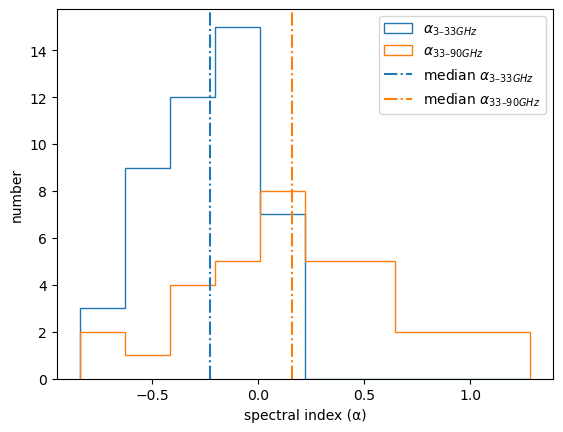

In [19]:
bins=np.histogram(np.hstack((specdf['alpha1'].dropna(),specdf['alpha2'].dropna())), bins=10)[1] 

print(specdf['alpha1'])

plt.hist(specdf['alpha1'].dropna(),label='$α_{3–33 GHz}$',histtype='step',color='#1f77b4',bins=bins)
plt.hist(specdf['alpha2'].dropna(),label='$α_{33–90 GHz}$',histtype='step',color='#ff7f0e',bins=bins)

for s in specdf['alpha2']:
    print(s)

plt.legend()
# plt.title('bins=10 (default)')
plt.xlabel('spectral index (α)')
plt.ylabel('number')
plt.axvline(np.median(specdf['alpha1'].dropna()),label='median $α_{3–33 GHz}$',
            color='#1f77b4',linestyle='-.')
plt.axvline(np.median(specdf['alpha2'].dropna()),label='median $α_{33–90 GHz}$',
            color='#ff7f0e',linestyle='-.')
# plt.axvline(np.median(specdf['alpha']),label='median $α_{3–90 GHz}$')
plt.legend()

print(np.median(specdf['alpha1']))
print(np.median(specdf['alpha2'].dropna()))
# print(np.median(specdf['alpha']))

#'#1f77b4', '#ff7f0e', '#2ca02c',